In [1]:
# Baza
import numpy as np
import pandas as pd
import scipy
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True, precision=4)

# Wykresy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import expon

# Model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import operator
from stargazer.stargazer import Stargazer, LineLocation
from IPython.core.display import HTML

Kod skomentowany nie powinien być odpalany, po prostu chce pokazać że coś robiłem ale ostatecznie nie wyszło
np. WLS i GLS: kod działa, ale ostatecznie użyłem macierzy odpornej, ale też nie chciałem usuwać tego kodu żeby było widać że przetestowałem inne opcje

In [2]:
### OBRÓBKA DANYCH
dfog = pd.read_csv('database_credit_score.csv')

#Drop columns
dfog = dfog[dfog.columns.drop(list(dfog.filter(regex='R_')))] #Drop kolumn z ratios (zastępują brakujące wartości losowymi (jak jest dzielenie przez 0))
dfog = dfog[dfog.columns.drop(["DEFAULT", "CUST_ID"])] # Drop niepotrzebnych kolumn (ID niepotrzebne, DEFAULT to alternatywna zero-jedynkowa zmienna objaśniana

#Dataframe do podsumowań charakterystyk zmiennych
dfogog = dfog.copy()

#Drop kolumn zależnych
dfog = dfog[dfog.columns.drop(["CAT_DEBT", "CAT_GAMBLING", "CAT_SAVINGS_ACCOUNT"])]

# Kolumna ze zmienną objaśnianą na przód (dla czytelności)
dfog.insert(0, "CREDIT_SCORE", dfog.pop("CREDIT_SCORE"))

# Sprawdzenie missing values
print("Brakujące wartości: " + str(dfog.isna().sum().sum()) + '\n')

#
df = dfog.copy()
df

Brakujące wartości: 0



CREDIT_SCORE  INCOME  SAVINGS     DEBT  T_CLOTHING_12  T_CLOTHING_6  \
0             444   33269        0   532304           1889           945   
1             625   77158    91187   315648           5818           111   
2             469   30917    21642   534864           1157           860   
3             559   80657    64526   629125           6857          3686   
4             473  149971  1172498  2399531           1978           322   
..            ...     ...      ...      ...            ...           ...   
995           418  328892  1465066  5501471          16701         10132   
996           589   81404    88805   680837           5400          1936   
997           499       0    42428    30760              0             0   
998           507   36011     8002   604181           1993          1271   
999           657   44266   309859    44266           1574          1264   

     T_EDUCATION_12  T_EDUCATION_6  T_ENTERTAINMENT_12  T_ENTERTAINMENT_6  \
0                 0              0                3068               1554   
1                 0              0               17244               8694   
2                 0              0                3611               2231   
3              4402           2215               13446               6849   
4                 0              0                5194               2675   
..              ...            ...                 ...                ...   
995               0              0                9778               4926   
996               0              0               28839              18396   
997               0              0                   0                  0   
998            9622           4819                3587               1831   
999               0              0                7496               3805   

     T_FINES_12  T_FINES_6  T_GAMBLING_12  T_GAMBLING_6  T_GROCERIES_12  \
0             0          0           1313           605            4849   
1             0          0              0             0            5224   
2            36         36           1201           609            4335   
3             0          0           7796          4056            4547   
4             0          0           1734           912           34814   
..          ...        ...            ...           ...             ...   
995           0          0           3216          1446           74781   
996           0          0              0             0            7033   
997           0          0              0             0             608   
998           0          0              0             0            6049   
999           0          0              0             0            8371   

     T_GROCERIES_6  T_HEALTH_12  T_HEALTH_6  T_HOUSING_12  T_HOUSING_6  \
0             2753          320           0          3006         1521   
1             2386          467         110         16339         8269   
2             2418          891         387          2759         1395   
3             2355         2068         795         12619         6387   
4            15369         7513        2581         42658        21589   
..             ...          ...         ...           ...          ...   
995          38607        14270        7337         79932        40453   
996           3590         1737         502             0            0   
997            345          147         113           780          394   
998           3576          871         348          3549         1796   
999           3973         9093        3911             0            0   

     T_TAX_12  T_TAX_6  T_TRAVEL_12  T_TRAVEL_6  T_UTILITIES_12  \
0           0        0        17893       11439             931   
1        1973      988        20234        3133            2845   
2           0        0        16072        9251             855   
3        1675      915        25038       11835            2209   
4        3941     1794        28167       

In [3]:
### ZMIENNE OBJAŚNIAJĄCE
dfogog.CAT_GAMBLING.replace(('High', 'Low', 'No'), (1, 1, 0), inplace=True)

dfcat = pd.DataFrame()
dfcat["variable"] = list(dfogog.filter(regex='CAT_'))
dfcat["percentage_of_1s"] = 0.0
for var in dfcat["variable"]:
    dfcat.loc[dfcat['variable'] == var, "percentage_of_1s"] = len(dfogog.loc[dfogog[var] == 1, var]) / len(dfogog) * 100
# display(dfcat)


dfvar = pd.DataFrame()
dfvar["variable"] = list(set(dfogog.columns) - set(list(dfogog.filter(regex='CAT_'))))
dfvar["max"] = 0.0
dfvar["min"] = 0.0
dfvar["mean"] = 0.0
dfvar["std"] = 0.0
for var in dfvar["variable"]:
    dfvar.loc[dfvar['variable'] == var, "max"] = dfogog[var].max()
    dfvar.loc[dfvar['variable'] == var, "min"] = dfogog[var].min()
    dfvar.loc[dfvar['variable'] == var, "mean"] = dfogog[var].mean()
    dfvar.loc[dfvar['variable'] == var, "std"] = dfogog[var].std()
    
display(dfvar)

C:\Users\barte\AppData\Local\Temp\ipykernel_16912\2729811066.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfogog.CAT_GAMBLING.replace(('High', 'Low', 'No'), (1, 1, 0), inplace=True)
C:\Users\barte\AppData\Local\Temp\ipykernel_16912\2729811066.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


variable        max     min      mean       std
0        T_EDUCATION_6   19327.00    0.00   1811.46   3551.44
1    T_ENTERTAINMENT_6   44066.00    0.00   7945.31   7374.46
2         T_CLOTHING_6   39918.00    0.00   3466.32   5118.94
3              T_TAX_6    8517.00    0.00   2072.06   2355.62
4           T_TRAVEL_6  158788.00    0.00  16675.37  22305.68
5         CREDIT_SCORE     800.00  300.00    586.71     63.41
6   T_ENTERTAINMENT_12   62529.00    0.00  14261.25  12388.19
7        T_CLOTHING_12   43255.00    0.00   6822.40   7486.23
8             T_TAX_12   17013.00    0.00   4110.76   4642.79
9        T_GAMBLING_12   22099.00    0.00   2433.59   5007.16
10         T_TRAVEL_12  216557.00    0.00  31762.33  35822.00
11                DEBT 5968620.00    0.00 790718.05 981790.39
12          T_HEALTH_6   33967.00    0.00   2657.59   3386.04
13         T_HOUSING_6   42143.00    0.00   5641.33   9055.32
14      T_UTILITIES_12   20504.00    0.00   6755.77   6313.71
15        T_HOUSING_12   83269.00    0.00  11146.71  17892.43
16     T_EXPENDITURE_6  286987.00  620.00  54247.77  49853.94
17      T_GROCERIES_12   94250.00  208.00  18027.60  19207.31
18    T_EXPENDITURE_12  472924.00 1177.00 104330.82  89250.19
19          T_FINES_12    1421.00    0.00     26.50    136.17
20           T_FINES_6    1082.00    0.00     14.46     88.51
21      T_EDUCATION_12   38229.00    0.00   3604.26   7065.70
22         T_HEALTH_12   45428.00    0.00   5379.65   5316.80
23       T_GROCERIES_6   56455.00   74.00   9327.59  10313.30
24              INCOME  662094.00    0.00 121610.02 113716.70
25        T_GAMBLING_6   11780.00    0.00   1241.62   2570.48
26       T_UTILITIES_6   10316.00    0.00   3394.66   3172.76
27             SAVINGS 2911863.00    0.00 413189.60 442916.04

### WYKRESY

In [4]:
df_wykresy = df.copy()
# Normalizacja zmiennych do skali 0-1
for i in list(df_wykresy.columns)[1:]:
    df_wykresy[i] = (df_wykresy[i] - min(df_wykresy[i]))/(max(df_wykresy[i]) - min(df_wykresy[i]))

SignificanceResult(statistic=337.4217058104912, pvalue=5.3679386797773716e-74)

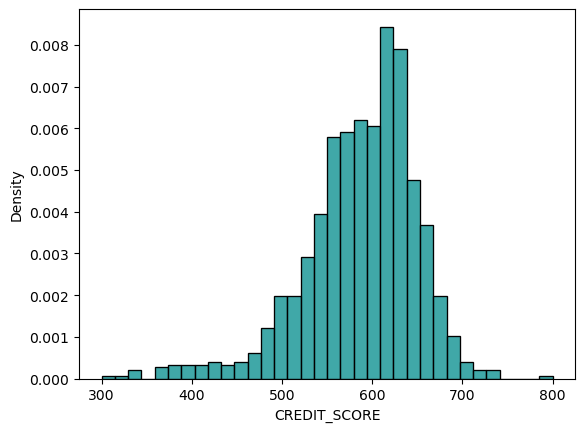

In [5]:
## 1. Histogram zmiennej objaśnianiej
sns.histplot(data=df_wykresy,x="CREDIT_SCORE", stat = "density", color = "darkcyan") 
#plt.savefig("hist.png", transparent=True, bbox_inches='tight')

# Test na normalność 
sm.stats.diagnostic.kstest_normal(df["CREDIT_SCORE"], dist='norm', pvalmethod='table')[1]
scipy.stats.jarque_bera(df["CREDIT_SCORE"])
# pvalue = 0.001 < 0.05, odrzucone H0, nie pochodzi z rozkładu normalnego

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'T_EXPENDITURE_12'),
  Text(1, 0, 'SAVINGS'),
  Text(2, 0, 'T_CLOTHING_12'),
  Text(3, 0, 'T_GROCERIES_12'),
  Text(4, 0, 'T_FINES_6'),
  Text(5, 0, 'T_GROCERIES_6'),
  Text(6, 0, 'T_EXPENDITURE_6'),
  Text(7, 0, 'T_CLOTHING_6'),
  Text(8, 0, 'T_EDUCATION_6'),
  Text(9, 0, 'T_EDUCATION_12'),
  Text(10, 0, 'CAT_DEPENDENTS'),
  Text(11, 0, 'T_GAMBLING_12'),
  Text(12, 0, 'T_GAMBLING_6'),
  Text(13, 0, 'CAT_CREDIT_CARD'),
  Text(14, 0, 'DEBT')])

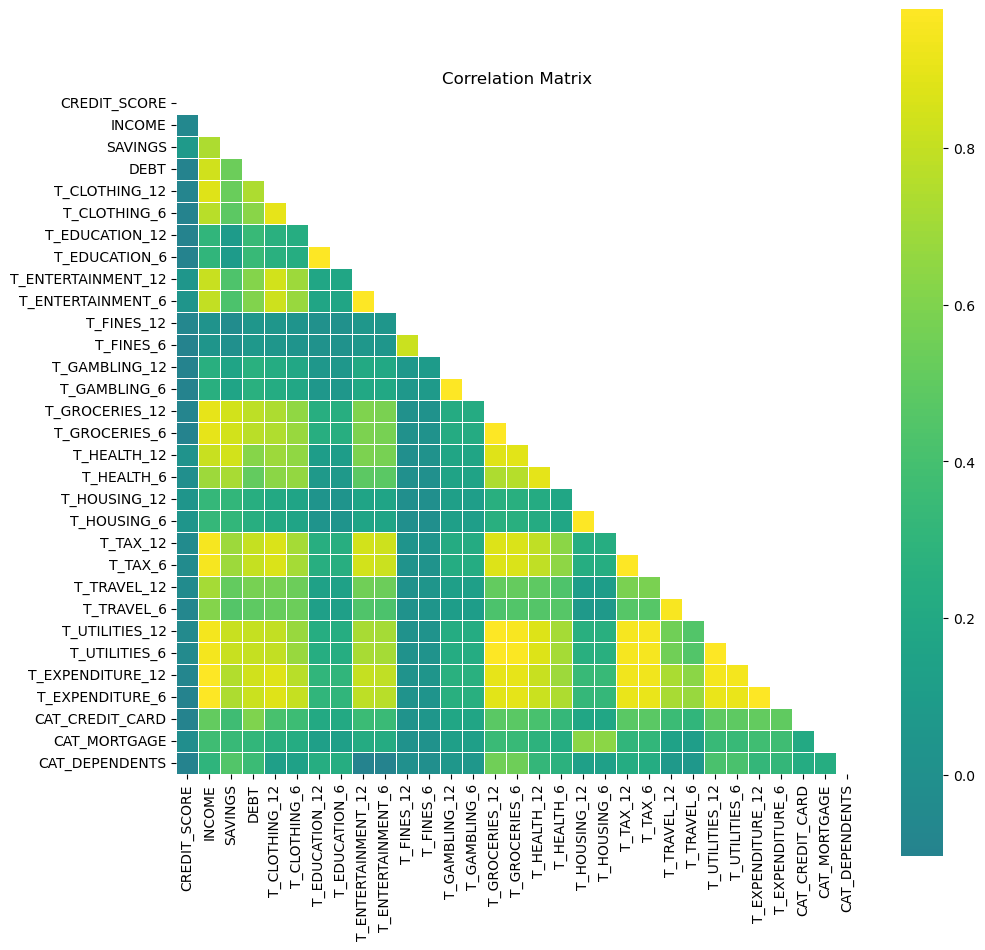

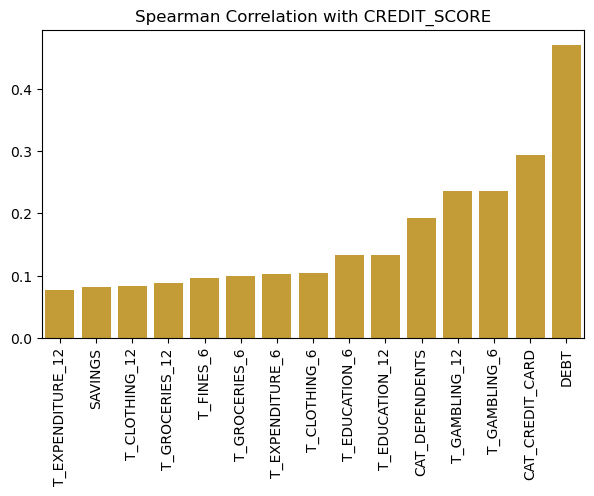

In [6]:
## 2. Macierz korelacji
plt.figure(figsize = (11,11))
corr = df_wykresy.corr(method = "spearman")
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0, square = True, cmap = "viridis", linewidths = .6)
plt.title('Correlation Matrix')
# plt.savefig("corrmatrix.png", transparent=True, bbox_inches='tight')

## 3. Ranking korelacji
plt.figure(figsize=(7,4))
# corr['CREDIT_SCORE'][1:].abs().sort_values().barplot(kind='bar', title='Highly correlated features with credit_score')
sns.barplot(corr['CREDIT_SCORE'][1:].abs().sort_values()[-15:], color="goldenrod")
plt.ylabel("")
plt.title("Spearman Correlation with CREDIT_SCORE")
plt.xticks(rotation=90)
# plt.savefig("corrranking.png", transparent=True, bbox_inches='tight')

In [7]:
## 4. Histogramy + dopasowanie krzywej rozkładu wykładniczego

# Testy dopasowania do rozkładu wykładniczego debt i income
print(sm.stats.diagnostic.kstest_normal(df["DEBT"], dist='exp', pvalmethod='table'))
print(sm.stats.diagnostic.kstest_normal(df["INCOME"], dist='exp', pvalmethod='table'))

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

x = np.linspace(0, 1, len(df_wykresy['DEBT']))
pdf_wykresy = expon.pdf(x, scale=np.mean(df_wykresy['DEBT']))
axs[0,0].plot(x, pdf_wykresy, color="darkred", linewidth=3)
axs[0,0].hist(df_wykresy['DEBT'], density=True, color="lightcoral", edgecolor = "black", bins=20)
axs[0,0].set_title('DEBT')

x = np.linspace(0, 1, len(df_wykresy['INCOME']))
pdf_wykresy = expon.pdf(x, scale=np.mean(df_wykresy['INCOME']))
axs[0,1].plot(x, pdf_wykresy, color="darkred", linewidth=3)
axs[0,1].hist(df_wykresy['INCOME'], density=True, color="lightcoral", edgecolor = "black", bins=20)
axs[0,1].set_title('INCOME')

x = np.linspace(0, 1, len(df_wykresy['T_EDUCATION_12']))
pdf_wykresy = expon.pdf(x, scale=np.mean(df_wykresy['T_EDUCATION_12']))
axs[1,0].plot(x, pdf_wykresy, color="goldenrod", linewidth=3)
axs[1,0].hist(df_wykresy['T_EDUCATION_12'], density=True, color="khaki", edgecolor = "black", bins=20)
axs[1,0].set_title('T_EDUCATION_12')

x = np.linspace(0, 1, len(df_wykresy['T_GAMBLING_12']))
pdf_wykresy = expon.pdf(x, scale=np.mean(df_wykresy['T_GAMBLING_6']))
axs[1,1].plot(x, pdf_wykresy, color="goldenrod", linewidth=3)
axs[1,1].hist(df_wykresy['T_GAMBLING_6'], density=True, color="khaki", edgecolor = "black", bins=20)
axs[1,1].set_title('T_GAMBLING_6')

# plt.savefig("varshists.png", transparent=True, bbox_inches='tight')

(0.21328066965055772, 0.0009999999999998899)
(0.05, 0.0010703352663832182)


Text(0.5, 1.0, 'T_GAMBLING_6')

### MODEL

In [8]:
### Funkcje biorące listy zmiennych wejściowych (kolumn dataframu) i zwracające listę modeli, gdzie każdy kolejny model jest bez 1 zmiennej nieistotnej (ostatni ma wszystkie istotne)
def testuj_modele(features, significant_level = 0.05):
    Y = df["CREDIT_SCORE"]
    X = sm.add_constant(df[features])
    # Pętla wyrzucająca po kolei wszystkie zmienne nieistotne
    models = []
    insignificant_feature = True
    while insignificant_feature:
            model = sm.OLS(Y, X)
            results = model.fit()
            models.append(results)
            significant = [p_value < significant_level for p_value in results.pvalues]
            if all(significant):
                insignificant_feature = False
            else:
                if X.shape[1] == 1:
                    print('No significant features found')
                    results = None
                    insignificant_feature = False
                else:    
                    a = model.exog_names[list(results.pvalues).index(max(results.pvalues))]      
                    X = X.drop(columns=[a])

    return models

def testuj_modele_HC0(features, significant_level = 0.05):
    Y = df["CREDIT_SCORE"]
    X = sm.add_constant(df[features])
    # Pętla wyrzucająca po kolei wszystkie zmienne nieistotne
    models = []
    insignificant_feature = True
    while insignificant_feature:
            model = sm.OLS(Y, X)
            results = model.fit(cov_type="HC0")
            models.append(results)
            significant = [p_value < significant_level for p_value in results.pvalues]
            if all(significant):
                insignificant_feature = False
            else:
                if X.shape[1] == 1:
                    print('No significant features found')
                    results = None
                    insignificant_feature = False
                else:    
                    a = model.exog_names[list(results.pvalues).index(max(results.pvalues))]      
                    X = X.drop(columns=[a])

    return models

def testuj_modele_GLS(features, significant_level = 0.05):
    Y = df["CREDIT_SCORE"]
    X = sm.add_constant(df[features])
    # Pętla wyrzucająca po kolei wszystkie zmienne nieistotne
    models = []
    insignificant_feature = True
    while insignificant_feature:
            model = sm.OLS(Y, X)
            results = model.fit()
            residuals = results.resid
            cov_matrix = np.diag(residuals**2)
            model = sm.GLS(Y, X, sigma=cov_matrix)
            results = model.fit()
            models.append(results)
            significant = [p_value < significant_level for p_value in results.pvalues]
            if all(significant):
                insignificant_feature = False
            else:
                if X.shape[1] == 1:
                    print('No significant features found')
                    results = None
                    insignificant_feature = False
                else:    
                    a = model.exog_names[list(results.pvalues).index(max(results.pvalues))]      
                    X = X.drop(columns=[a])

    return models

def testuj_modele_WLS(features, significant_level = 0.05):
    Y = df["CREDIT_SCORE"]
    X = sm.add_constant(df[features])
    # Pętla wyrzucająca po kolei wszystkie zmienne nieistotne
    models = []
    insignificant_feature = True
    while insignificant_feature:
            errors = Y - np.mean(Y)
            error_variance = np.var(errors)
            weights = 1 / error_variance
            model = sm.WLS(Y, X, weights=weights)
            results = model.fit()
            models.append(results)
            significant = [p_value < significant_level for p_value in results.pvalues]
            if all(significant):
                insignificant_feature = False
            else:
                if X.shape[1] == 1:
                    print('No significant features found')
                    results = None
                    insignificant_feature = False
                else:    
                    a = model.exog_names[list(results.pvalues).index(max(results.pvalues))]      
                    X = X.drop(columns=[a])

    return models

def diagnostyka(model, significant_level = 0.05):
    reset = sm.stats.diagnostic.linear_reset(model, power = 2, test_type = "fitted")
    print(reset)
    if (reset.pvalue > significant_level):
        print("Spełnione założenie o liniowości")
    else:
        print("NIE spełnione założenie o liniowości")

    print('\n')
    ### HOMOSKEDASTYCZNOŚĆ
    bp = sm.stats.diagnostic.het_breuschpagan(resid = model.resid, exog_het = model.model.exog)
    print(bp)
    if (bp[1] > significant_level):
        print("Spełnione założenie o homoskedastyczności")
    else:
        print("NIE spełnione założenie o homoskedastyczności")
        
    print('\n')
    ### NORMALNOŚĆ RESZT
    jb = scipy.stats.jarque_bera(model.resid)
    print(jb)
    if (jb.pvalue > significant_level):
        print("Spełnione założenie o normalności reszt")
    else:
        print("NIE spełnione założenie o normalności reszt")
        
    print('\n')
    ### AUTOKORELACJA
    bg = sm.stats.diagnostic.acorr_breusch_godfrey(model)
    print(bg)
    if (bg[1] > significant_level):
        print("Spełnione założenie o autokorelacji")
    else:
        print("NIE spełnione założenie o autokorelacji")
        
    print('\n')
    ### ŁĄCZNA ISTOTNOŚĆ ZMIENNYCH
    print(model.f_pvalue)
    if (model.f_pvalue < significant_level):
        print("Zmienne są łącznie istotnie")
    else:
        print("Zmienne NIE są łącznie istotnie")

In [9]:
### MODEL0
df = dfog.copy()
features = list(df.columns)
features.remove("CREDIT_SCORE")
features.remove("T_EXPENDITURE_12")
features.remove("T_EXPENDITURE_6")

### SUMMARY
models0 = testuj_modele(features, 0.05)
stgz = [models0[-8], models0[-6], models0[-4], models0[-3], models0[-2], models0[-1]]
stargazer = Stargazer(models=stgz)
stargazer.add_line("AIC", list((round(i.aic, 2) for i in stgz)), LineLocation.FOOTER_BOTTOM)
# display(HTML(stargazer.render_html()))
# stargazer.render_html()
model0 = models0[-1]
diagnostyka(model0)
model0.summary()

<Wald test (chi2): statistic=0.4555228423427562, p-value=0.4997238461043253, df_denom=1>
Spełnione założenie o liniowości


(87.33694811968029, 1.6148052422410412e-13, 7.870882871881283, 3.689355993783871e-14)
NIE spełnione założenie o homoskedastyczności


SignificanceResult(statistic=709.8151144074039, pvalue=7.338483475962255e-155)
NIE spełnione założenie o normalności reszt


(10.586495109391358, 0.39062727108477857, 1.0453673485100796, 0.4027215133389966)
Spełnione założenie o autokorelacji


2.0040957537986917e-103
Zmienne są łącznie istotnie


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     56.55
Date:                Wed, 15 Jan 2025   Prob (F-statistic):          2.00e-103
Time:                        15:01:00   Log-Likelihood:                -5306.5
No. Observations:                1000   AIC:                         1.064e+04
Df Residuals:                     987   BIC:                         1.070e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                568.7304      3.088    184.149      0.000     562.670     574.791
INCOME                 0.0005   6.53e-05      8.043      0.000       0.000       0.001
SAVINGS             2.133e-05    6.5e-06      3.282      0.001    8.58e-06    3.41e-05
DEBT               -5.596e-05   2.78e-06    -20.107      0.000   -6.14e-05   -5.05e-05
T_CLOTHING_12         -0.0015      0.000     -3.706      0.000      -0.002      -0.001
T_ENTERTAINMENT_12     0.0057      0.001      5.583      0.000       0.004       0.008
T_ENTERTAINMENT_6     -0.0072      0.001     -5.238      0.000      -0.010      -0.005
T_GAMBLING_6          -0.0042      0.001     -5.794      0.000      -0.006      -0.003
T_GROCERIES_12        -0.0012      0.000     -2.884      0.004      -0.002      -0.000
T_HEALTH_12            0.0014      0.001      2.557      0.011       0.000       0.002
T_TAX_6               -0.0137      0.004     -3.633      0.000      -0.021      -0.006
T_TRAVEL_6            -0.0006      0.000     -4.011      0.000      -0.001      -0.000
T_UTILITIES_12         0.0049      0.002      2.152      0.032       0.000       0.009
==============================================================================
Omnibus:                      217.745   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              709.815
Skew:                          -1.047   Prob(JB):                    7.34e-155
Kurtosis:                       6.557   Cond. No.                     2.69e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

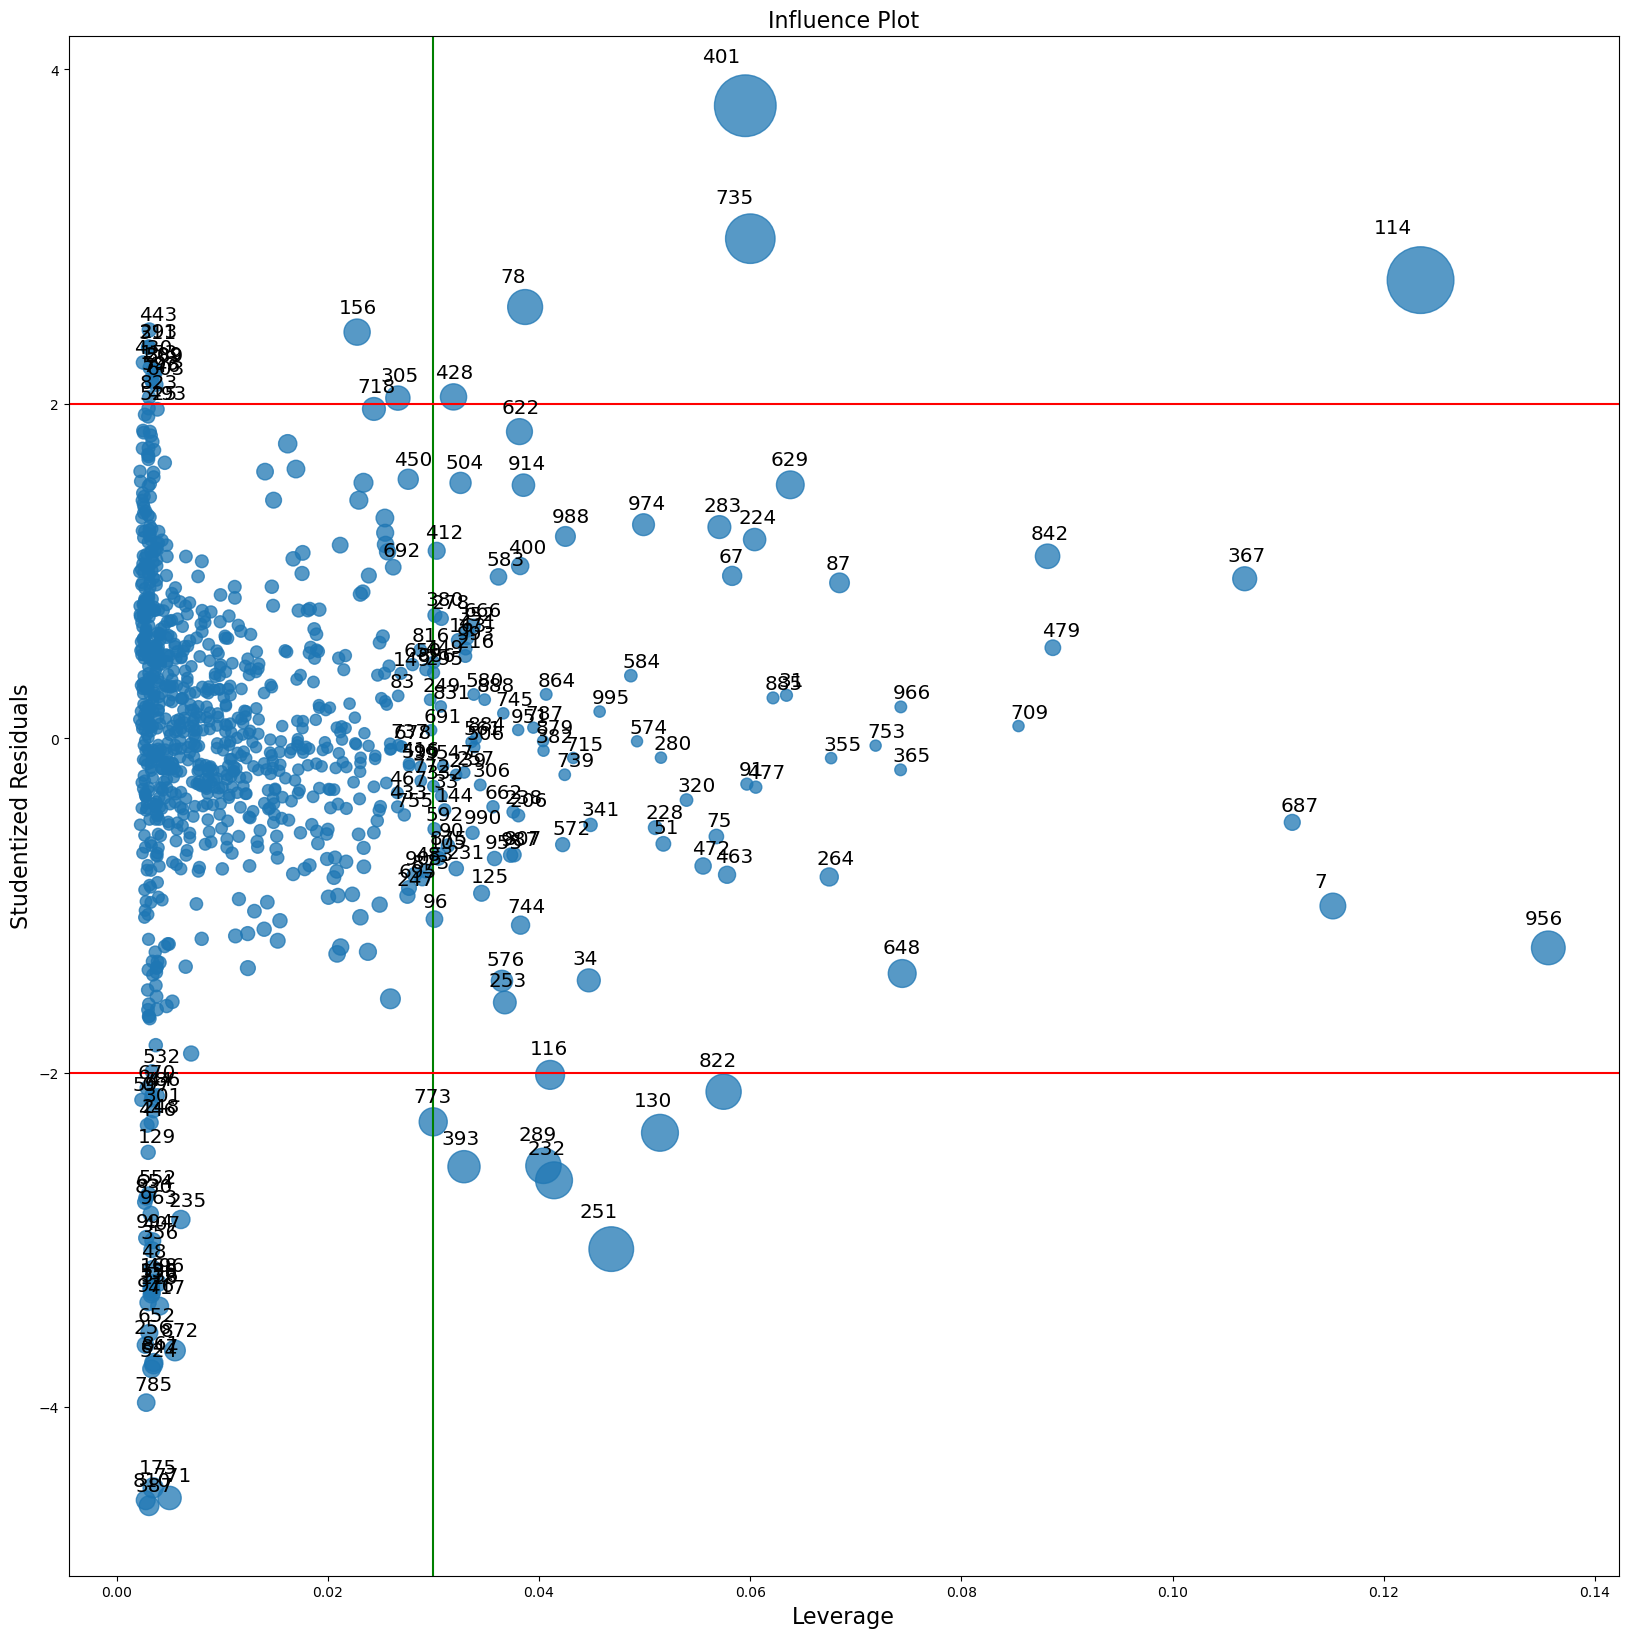

% obserwacji odstających: 4.2


In [10]:
### OBSERWACJE ODSTAJĄCE

### WYKRESs
with plt.rc_context():
    plt.rc("figure", figsize=(20, 20))
    sm.graphics.influence_plot(model0)
    plt.axvline(x = round((2*len(model0.params))/model0.nobs, 2), color = 'g')
    plt.axhline(y = 2, color = 'r')
    plt.axhline(y = -2, color = 'r')
    plt.show()

### COOK
dfcook = df.copy()
dfcook['cooks'] = model0.get_influence().cooks_distance[0]
meancook = dfcook['cooks'].mean()
dfcook = dfcook[dfcook['cooks'] > 4 * meancook]
print("% obserwacji odstających: " + str(round(len(dfcook) / len(df), 4)*100))

In [11]:
### WSPÓŁLINIOWOŚĆ
### Multicollinearity
vif_model0 = pd.DataFrame()
X_vif = sm.add_constant(df[model0.model.exog_names[1:]])
vif_model0["feature"] = X_vif.columns
vif_model0["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
vif_model0.sort_values(by="VIF", ascending=False)

feature   VIF
12      T_UTILITIES_12 87.24
5   T_ENTERTAINMENT_12 66.15
6    T_ENTERTAINMENT_6 42.61
10             T_TAX_6 32.44
8       T_GROCERIES_12 26.25
1               INCOME 22.82
11          T_TRAVEL_6  4.42
4        T_CLOTHING_12  4.03
0                const  3.95
9          T_HEALTH_12  3.52
2              SAVINGS  3.43
3                 DEBT  3.09
7         T_GAMBLING_6  1.43

In [12]:
### MODEL1
df = dfog.copy()

###### MODYFIKACJA ZMIENNYCH
### RATIOS
df["R_EXPENDITURE_INCOME"] = df["T_EXPENDITURE_12"] / df["INCOME"]
# df["R_SAVINGS_INCOME"] = df["SAVINGS"] / df["INCOME"]
# df["R_DEBT_SAVINGS"] = df["DEBT"] / df["SAVINGS"]
# Zastąpienie wartości brakujących
ratios = list(df.filter(regex='R_'))
for ratio in ratios:
    df.loc[df[ratio] == float('inf'), ratio] = df[ratio][df[ratio] != float('inf')].max()
    df[ratio] = df[ratio].fillna(df[ratio][df[ratio] != float('inf')].max())

### LOGARYTMY
log = ['T_ENTERTAINMENT_12', 'T_UTILITIES_12', 'T_TRAVEL_6', 'T_TRAVEL_12', 'T_CLOTHING_6']
for x in log:
    df[x] = df[x].astype(float)
    df.loc[df[x] == 0, x] = 0.01
    df[x] = np.log(df[x])
    df.rename(columns = {x : str(x+"_ln")}, inplace=True)

### SQUARE
# sqr = ['INCOME']#, 'T_HEALTH_6', 'T_GAMBLING_12']
# for s in sqr:
#     df[str(s + "_sq")] = df[s]*df[s]

### INTERAKCJE
# df["DEBTxCREDIT_CARD"] = df['DEBT'] * df['CAT_CREDIT_CARD']
# df["GROCERIES12xDEPENDANTS"] = df['T_GROCERIES_12'] * df['CAT_DEPENDENTS']
# df["GROCERIES6xDEPENDANTS"] = df['T_GROCERIES_6'] * df['CAT_DEPENDENTS']


# Zmienne objaśniające w modelu
features = list(df.columns)
features.remove("CREDIT_SCORE")
features.remove("T_EXPENDITURE_12")
features.remove("T_EXPENDITURE_6")

# DF do testowania hipotez
dfbest = df.copy()

# Model1
# models1 = testuj_modele(features, 0.05)
# stargazer = Stargazer([models1[-len(models1)], models1[-int(len(models1)/2)], models1[-1]])
# display(HTML(stargazer.render_html()))
# model1 = models1[-1]
# diagnostyka(model1)
# model1.summary()

### GENERALISED LEAST SQUARES
# gls_model = testuj_modele_GLS(features)[-1]
# diagnostyka(gls_model)
# gls_model.summary()

### WEIGHTED LEAST SQUARES
# wls_model = testuj_modele_WLS(features)[-1]
# diagnostyka(wls_model)
# wls_model.summary()

### Model z macierzą odporną
# model1HC0 = testuj_modele_HC0(features, 0.05)[-1]
# diagnostyka(model1HC0)
# model1HC0.summary()

### SUMMARY
models1HC0 = testuj_modele_HC0(features, 0.05)
stgz = [models1HC0[-8], models1HC0[-6], models1HC0[-4], models1HC0[-3], models1HC0[-2], models1HC0[-1]]
stargazer = Stargazer(models=stgz)
stargazer.add_line("AIC", list((round(i.aic, 2) for i in stgz)), LineLocation.FOOTER_BOTTOM)
# display(HTML(stargazer.render_html()))
# stargazer.render_html()
model1HC0 = models1HC0[-1]
diagnostyka(model1HC0)
model1HC0.summary()

<Wald test (chi2): statistic=0.5047319327849625, p-value=0.47742829821787447, df_denom=1>
Spełnione założenie o liniowości


(47.28333903170234, 1.7263894366542276e-05, 3.491825823256906, 1.314451516087888e-05)
NIE spełnione założenie o homoskedastyczności


SignificanceResult(statistic=1014.4896919461482, pvalue=5.085836801067045e-221)
NIE spełnione założenie o normalności reszt


(14.953166730669043, 0.13377866511584655, 1.4800654211911368, 0.14146242825622402)
Spełnione założenie o autokorelacji


1.8351408033520698e-87
Zmienne są łącznie istotnie


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     40.60
Date:                Wed, 15 Jan 2025   Prob (F-statistic):           1.84e-87
Time:                        15:01:01   Log-Likelihood:                -5276.0
No. Observations:                1000   AIC:                         1.058e+04
Df Residuals:                     985   BIC:                         1.066e+04
Df Model:                          14                                         
Covariance Type:                  HC0                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  632.7602      9.940     63.661      0.000     613.279     652.241
INCOME                   0.0004   5.95e-05      6.285      0.000       0.000       0.000
SAVINGS               1.626e-05   5.97e-06      2.723      0.006    4.56e-06     2.8e-05
DEBT                 -5.786e-05   3.46e-06    -16.700      0.000   -6.46e-05   -5.11e-05
T_GAMBLING_6            -0.0025      0.001     -3.819      0.000      -0.004      -0.001
T_GROCERIES_12          -0.0023      0.000     -6.650      0.000      -0.003      -0.002
T_HEALTH_12              0.0035      0.001      4.194      0.000       0.002       0.005
T_HEALTH_6              -0.0029      0.001     -2.654      0.008      -0.005      -0.001
T_HOUSING_12             0.0003      0.000      2.470      0.013    5.61e-05       0.000
T_TAX_6                 -0.0165      0.003     -4.725      0.000      -0.023      -0.010
T_TRAVEL_12_ln          14.8148      3.147      4.707      0.000       8.647      20.983
T_TRAVEL_6_ln          -15.7707      3.364     -4.688      0.000     -22.365      -9.177
T_UTILITIES_12_ln       -5.4892      0.456    -12.029      0.000      -6.384      -4.595
T_UTILITIES_6            0.0228      0.004      5.495      0.000       0.015       0.031
R_EXPENDITURE_INCOME   -27.1991      7.348     -3.702      0.000     -41.601     -12.798
==============================================================================
Omnibus:                      285.079   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1014.490
Skew:                          -1.345   Prob(JB):                    5.09e-221
Kurtosis:                       7.137   Cond. No.                     1.06e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.06e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
### HIPOTEZY

### 1.1
dfh11 = dfbest.copy()
hip11 = 'INCOME = 0'
features = list(dfh11.columns)
features.remove("CREDIT_SCORE")
features.remove("T_EXPENDITURE_12")
features.remove("T_EXPENDITURE_6")
m1 = sm.OLS(dfh11["CREDIT_SCORE"], dfh11[features]).fit(cov_type="HC0")
print("TEST HIPOTEZY 1.1")
print(m1.t_test(hip11))
print('\n')

### 1.2
dfh12 = dfbest.copy()
dfh12["INCOME_sq"] = dfh12["INCOME"] * dfh12["INCOME"]
hip12_1 = 'INCOME_sq = 0'
hip12_2 = '(INCOME = 0), (INCOME_sq = 0)'
features = list(dfh12.columns)
features.remove("CREDIT_SCORE")
features.remove("T_EXPENDITURE_12")
features.remove("T_EXPENDITURE_6")
m1 = sm.OLS(dfh12["CREDIT_SCORE"], dfh12[features]).fit(cov_type="HC0")
print("TEST HIPOTEZY 1.2")
print(m1.t_test(hip12_1))
print(m1.f_test(hip12_2))
print('\n')

### 2
dfh2 = dfbest.copy()
dfh2['DEBT'] = dfh2['DEBT'].astype(float)
dfh2.loc[dfh2['DEBT'] == 0, 'DEBT'] = 0.01
dfh2['DEBT'] = np.log(dfh2['DEBT'])
dfh2.rename(columns = {'DEBT' : 'DEBT_ln'}, inplace=True)
hip2 = 'DEBT_ln = 0'
features = list(dfh2.columns)
features.remove("CREDIT_SCORE")
features.remove("T_EXPENDITURE_12")
features.remove("T_EXPENDITURE_6")
m2 = sm.OLS(dfh2["CREDIT_SCORE"], dfh2[features]).fit(cov_type="HC0")
print("TEST HIPOTEZY 2")
print(m2.t_test(hip2))
print('\n')

### 3.1
### exponential <- nie działa ze względu na inf po np.exp, nie ma dobrego sposobu żeby inf zastąpić
# dfh3["T_GAMBLING_6"] = ((dfh3["T_GAMBLING_6"] - dfh3["T_GAMBLING_6"].min())/(dfh3["T_GAMBLING_6"].max()-dfh3["T_GAMBLING_6"].min()))
# dfh3["T_GAMBLING_6"] = dfh3["T_GAMBLING_6"]*100
# dfh3["T_GAMBLING_6"] = np.exp(dfh3["T_GAMBLING_6"])
# hip3 = 'T_GAMBLING_6 = 0'
### squared
dfh31 = dfbest.copy()
dfh31["T_GAMBLING_6"] = dfh31["T_GAMBLING_6"] * dfh31["T_GAMBLING_6"]
dfh31["T_GAMBLING_12"] = dfh31["T_GAMBLING_12"] * dfh31["T_GAMBLING_12"]
hip31 = '(T_GAMBLING_6 = 0), (T_GAMBLING_12 = 0)'
features = list(dfh31.columns)
features.remove("CREDIT_SCORE")
features.remove("T_EXPENDITURE_12")
features.remove("T_EXPENDITURE_6")
m3 = sm.OLS(dfh31["CREDIT_SCORE"], dfh31[features]).fit(cov_type="HC0")
print("TEST HIPOTEZY 3.1")
print(m3.t_test(hip31))
print('\n')

### 3.2
dfh32 = dfbest.copy()
dfh32["T_GAMBLING_6"] = dfh32["T_GAMBLING_6"] + dfh32["T_GAMBLING_12"]
dfh32.loc[dfh32["T_GAMBLING_6"] > 0, "T_GAMBLING_6"] = 1
dfh32 = dfh32[dfh32.columns.drop(["T_GAMBLING_12"])]
hip32 = 'CAT_GAMBLING = 0'
dfh32.rename(columns = {"T_GAMBLING_6" : "CAT_GAMBLING"}, inplace=True)
features = list(dfh32.columns)
features.remove("CREDIT_SCORE")
features.remove("T_EXPENDITURE_12")
features.remove("T_EXPENDITURE_6")
m3 = sm.OLS(dfh32["CREDIT_SCORE"], dfh32[features]).fit(cov_type="HC0")
print("TEST HIPOTEZY 3.2")
print(m3.t_test(hip32))

TEST HIPOTEZY 1.1
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0007      8e-05      9.049      0.000       0.001       0.001


TEST HIPOTEZY 1.2
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0         -8.514e-10   1.75e-10     -4.876      0.000   -1.19e-09   -5.09e-10
<F test: F=68.39938647471368, p=1.6254988227412937e-28, df_denom=970, df_num=2>


TEST HIPOTEZY 2
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------